# Foreign Exchange Forecasting using LSTMs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.metrics import RootMeanSquaredError

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error

2023-10-01 23:36:04.948791: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-01 23:36:04.983489: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-01 23:36:05.576461: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Hyperparameter

In [67]:
# Google Spreadsheet ID
SHEET_ID = '1JDNv_mArl-GPIpxuWS5GxgVEwvjXocS1MrXGc6TYs8M'
SHEET_NAME = ['USD/IDR', 'EUR/IDR', 'JPY/IDR']

SEQ_LEN = 21 # 6, 11, 21
FOLD = 10 # 5, 10
LSTM_Layer = 3 # 1, 2, 3
WINDOW_SIZE = SEQ_LEN - 1

## Data Overview
From Google Finance

In [68]:
url = f'https://docs.google.com/spreadsheets/d/{SHEET_ID}/gviz/tq?tqx=out:csv&sheet={SHEET_NAME[1]}'
df = pd.read_csv(url)

# Convert from 100 JPY/IDR to 1 JPY/IDR
# df.replace(12480.17, 124.801, inplace=True) # Only for JPY/IDR

# Convert Date columns to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y %H:%M:%S')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1977 entries, 0 to 1976
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1977 non-null   datetime64[ns]
 1   Close   1977 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 31.0 KB


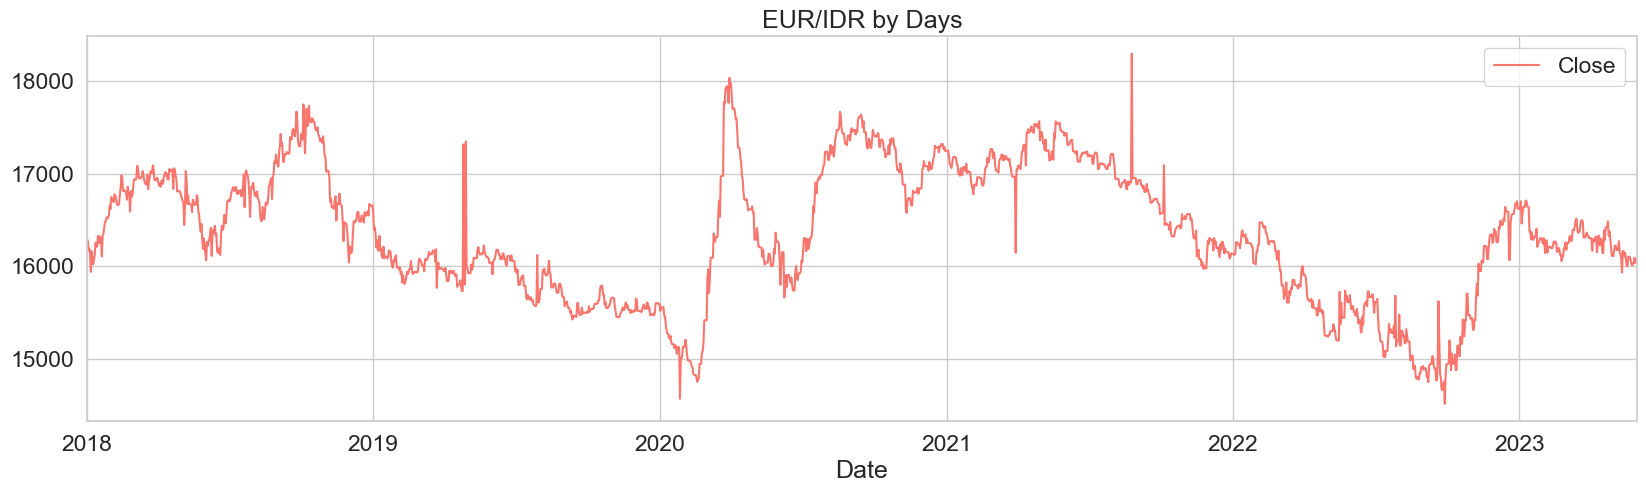

In [69]:
dfplot = df.copy()
dfplot = dfplot.groupby([pd.Grouper(key='Date', freq='D')]).first().reset_index()
dfplot = dfplot.set_index('Date')

color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = dfplot.plot(style='', figsize=(20,5), color=color_pal[0], title=f'{SHEET_NAME[1]} by Days')

## Data preprocessing

### Normalize

In [70]:
scaler = MinMaxScaler()
close_price = df.Close.values.reshape(-1, 1)
scaled_close = scaler.fit_transform(close_price)
scaled_close.shape

(1977, 1)

### Sliding Window

In [71]:
def to_sequences(data, seq_len):
    d = []
    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])
    return np.array(d)

def preprocess(data_raw, seq_len):
    data = to_sequences(data_raw, seq_len)
    target = data[:, -1, :]
    train = data[:, :-1, :]
    return train, target

inputs, targets = preprocess(scaled_close, SEQ_LEN)

tscv = TimeSeriesSplit(n_splits=FOLD)

## Modeling

### Building LSTM Model with Cross-Validation

In [72]:
BATCH_SIZE = 32
VAL_SPLIT = 0.1
EPOCH = 50

fold_no = 1
metrics_per_fold = [[] for _ in range(3)]
metrics_inverse_per_fold = [[] for _ in range(3)]
y_test_per_fold, y_hat_inverse_per_fold = [], []
history_per_fold = []

In [73]:
for train, test in tscv.split(inputs, targets):
    tf.keras.backend.clear_session()
    
    model = Sequential()
    for i, units in enumerate([128, 64, 32][:LSTM_Layer]):
        model.add(LSTM(units, return_sequences=(i < LSTM_Layer - 1), input_shape=(WINDOW_SIZE, 1)))
    model.add(Dense(1))
    
    model.compile(loss='mean_squared_error',
                  metrics=['mae', RootMeanSquaredError()],
                  optimizer='adam')

    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    
    history = model.fit(inputs[train],
                        targets[train],
                        epochs=EPOCH,
                        batch_size=BATCH_SIZE,
                        validation_split=VAL_SPLIT,
                        verbose=0)
    
    history_per_fold.append(history)
    
    # Model Evaluation
    scores = model.evaluate(inputs[test], targets[test], verbose=0)
    
    # Model Prediction
    y_hat = model.predict(inputs[test])
    y_test_inverse = scaler.inverse_transform(targets[test])
    y_hat_inverse = scaler.inverse_transform(y_hat)
    
    y_test_per_fold.append(y_test_inverse)
    y_hat_inverse_per_fold.append(y_hat_inverse)
    
    # Model Prediction Metrics
    mse_inverse = mean_squared_error(y_test_inverse, y_hat_inverse)
    mae_inverse = mean_absolute_error(y_test_inverse, y_hat_inverse)
    rmse_inverse = np.sqrt(mse_inverse)
       
    mse = mean_squared_error(targets[test], y_hat)
    mae = mean_absolute_error(targets[test], y_hat)
    rmse = np.sqrt(mse)

    print("Model Evaluate (model.evaluate) Result")
    print(f'Score for fold {fold_no}: {model.metrics_names[1]} is {scores[1]}; {model.metrics_names[0]}/mse is {scores[0]}; {model.metrics_names[2]} is {scores[2]}\n')
    
    print("Model Predict (model.predict) Result")
    print(f'Score for fold {fold_no}: mae is {mae}; mse is {mse}; rmse is {rmse}')
    print(f'Score for fold {fold_no}: mae is {mae_inverse}; mse is {mse_inverse}; rmse is {rmse_inverse}\n')

    fold_no += 1
    
    metrics_inverse_per_fold[0].append(mae_inverse) # MAE Inverse
    metrics_inverse_per_fold[1].append(mse_inverse) # MSE Inverse
    metrics_inverse_per_fold[2].append(rmse_inverse) # RMSE Inverse
    
    metrics_per_fold[0].append(mae) # MAE
    metrics_per_fold[1].append(mse) # MSE
    metrics_per_fold[2].append(rmse) # RMSE

------------------------------------------------------------------------
Training for fold 1 ...
6/6 [==============================] - 1s 47ms/step
Model Evaluate (model.evaluate) Result
Score for fold 1: mae is 0.052555155009031296; loss/mse is 0.004088388755917549; root_mean_squared_error is 0.06394051015377045

Model Predict (model.predict) Result
Score for fold 1: mae is 0.05255515746594304; mse is 0.0040883890702893885; rmse is 0.0639405119645549
Score for fold 1: mae is 198.86877767831928; mse is 58540.25483097966; rmse is 241.9509347594666

------------------------------------------------------------------------
Training for fold 2 ...
6/6 [==============================] - 1s 45ms/step
Model Evaluate (model.evaluate) Result
Score for fold 2: mae is 0.0418129488825798; loss/mse is 0.0033524695318192244; root_mean_squared_error is 0.05790051445364952

Model Predict (model.predict) Result
Score for fold 2: mae is 0.0418129498934268; mse is 0.003352470006110141; rmse is 0.05790051

## Model Evaluation

In [74]:
title = ['MAE', 'MSE', 'RMSE']
for i, unit in enumerate(metrics_per_fold):
    print(f"----------- {title[i]} -----------")
    print(f"Value per Fold : {unit}")
    print(f"Average Training Value : {np.mean(unit)}\n")

----------- MAE -----------
Value per Fold : [0.05255515746594304, 0.0418129498934268, 0.023964047901515455, 0.039566950033901094, 0.018111208638451264, 0.038427060169143344, 0.01672418463113518, 0.01775858157016046, 0.029599609022278105, 0.01717728300925361]
Average Training Value : 0.029569703233520834

----------- MSE -----------
Value per Fold : [0.0040883890702893885, 0.003352470006110141, 0.0008583110327581388, 0.0030191415459826063, 0.0005740350703649521, 0.0020101941417396347, 0.0014610070669835418, 0.0005694805433174184, 0.001552835948174695, 0.0006088966596175763]
Average Training Value : 0.001809476108533809

----------- RMSE -----------
Value per Fold : [0.0639405119645549, 0.057900518185160836, 0.029296945792320037, 0.05494671551587598, 0.023959028994618128, 0.044835188655113684, 0.03822312215117365, 0.023863791469869545, 0.03940603948856945, 0.024675831487866347]
Average Training Value : 0.04010476937051226



In [75]:
for i, unit in enumerate(metrics_inverse_per_fold):
    print(f"----------- {title[i]} -----------")
    print(f"Value per Fold : {unit}")
    print(f"Average Training Value : {np.mean(unit)}\n")

----------- MAE -----------
Value per Fold : [198.86877767831928, 158.2201027983756, 90.67996182026839, 149.7213678442797, 68.53279089336165, 145.40811131709032, 63.284260019420834, 67.19845736228821, 112.00492341984446, 64.9988109110171]
Average Training Value : 111.89175640642654

----------- MSE -----------
Value per Fold : [58540.25483097966, 48002.82214612104, 12289.859282335814, 43230.066394773065, 8219.401197677576, 28783.308448390148, 20919.663121891557, 8154.194978768728, 22234.513935398714, 8718.576955892839]
Average Training Value : 25909.266129222917

----------- RMSE -----------
Value per Fold : [241.9509347594666, 219.0954635452798, 110.85963775123845, 207.91841283246913, 90.6609132850402, 169.656442401667, 144.63631328919982, 90.3005812759183, 149.11242045986214, 93.3733203645069]
Average Training Value : 151.75644399646484



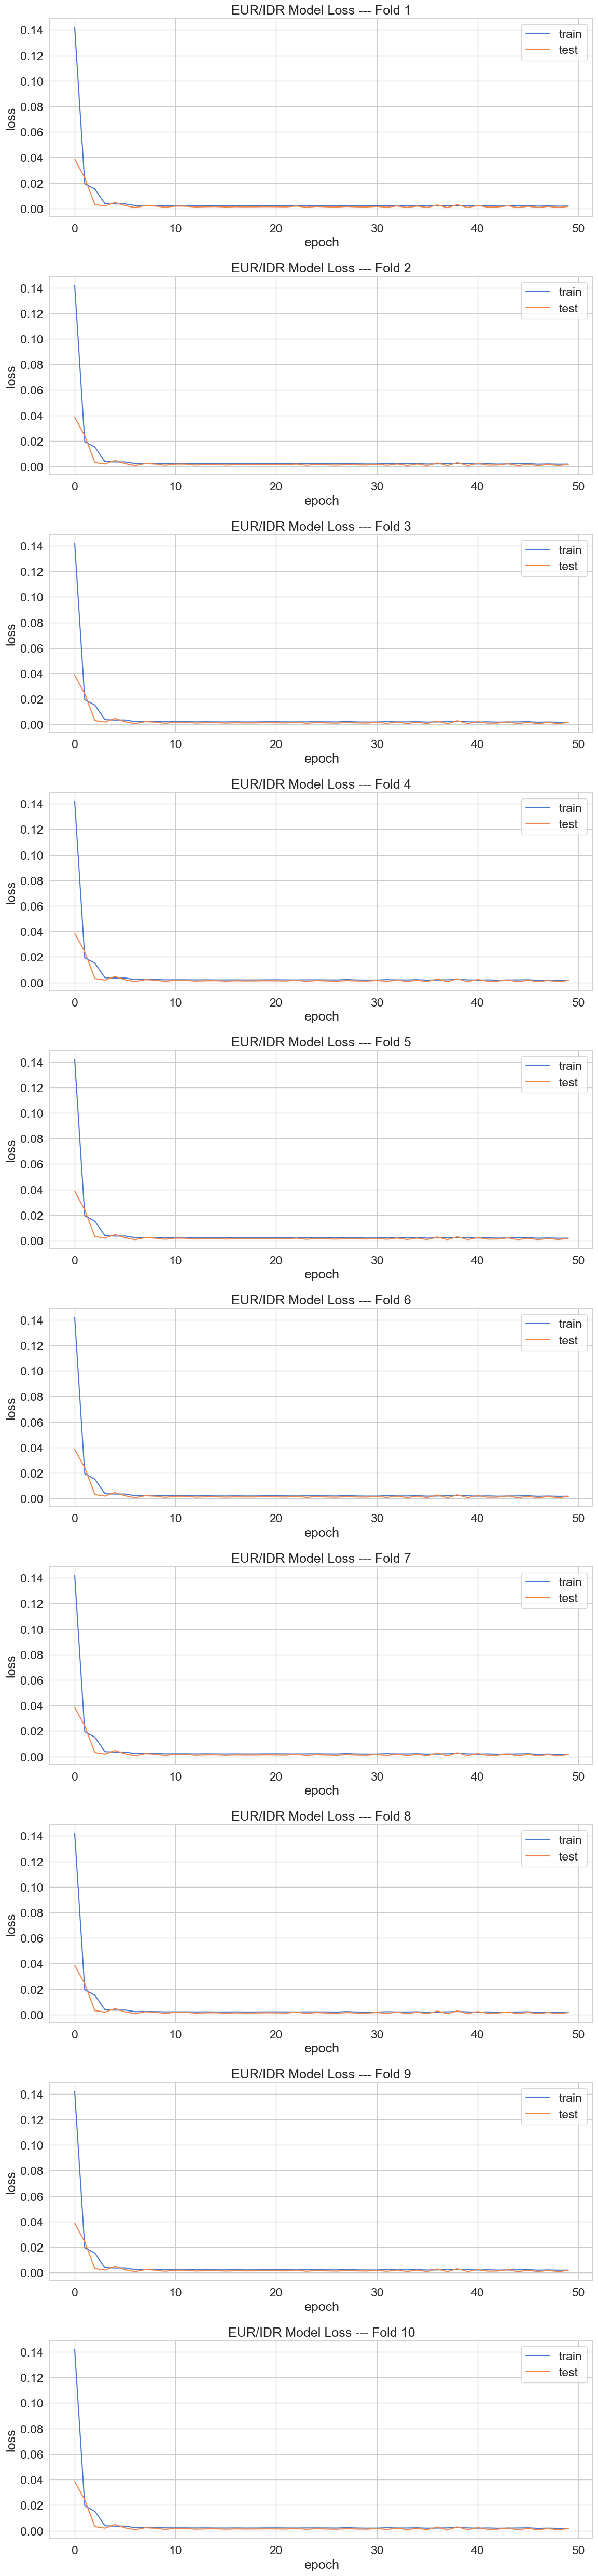

In [76]:
fig, axs = plt.subplots(FOLD, figsize=(12, FOLD*5))
for i in range(FOLD):
    axs[i].plot(history_per_fold[0].history['loss'])
    axs[i].plot(history_per_fold[0].history['val_loss'])

    axs[i].set_title(f'{SHEET_NAME[1]} Model Loss --- Fold {i+1}')
    axs[i].set_xlabel('epoch')
    axs[i].set_ylabel('loss')
    axs[i].legend(['train', 'test'], loc='best')

plt.tight_layout()
plt.savefig(f'D:/Collage/Courses/Skripsi/Gambar/Hasil Skenario/{SHEET_NAME[1][:3]} Model Loss_LSTM_{LSTM_Layer}_CV_{FOLD}_Window_{WINDOW_SIZE}.png')
plt.show()

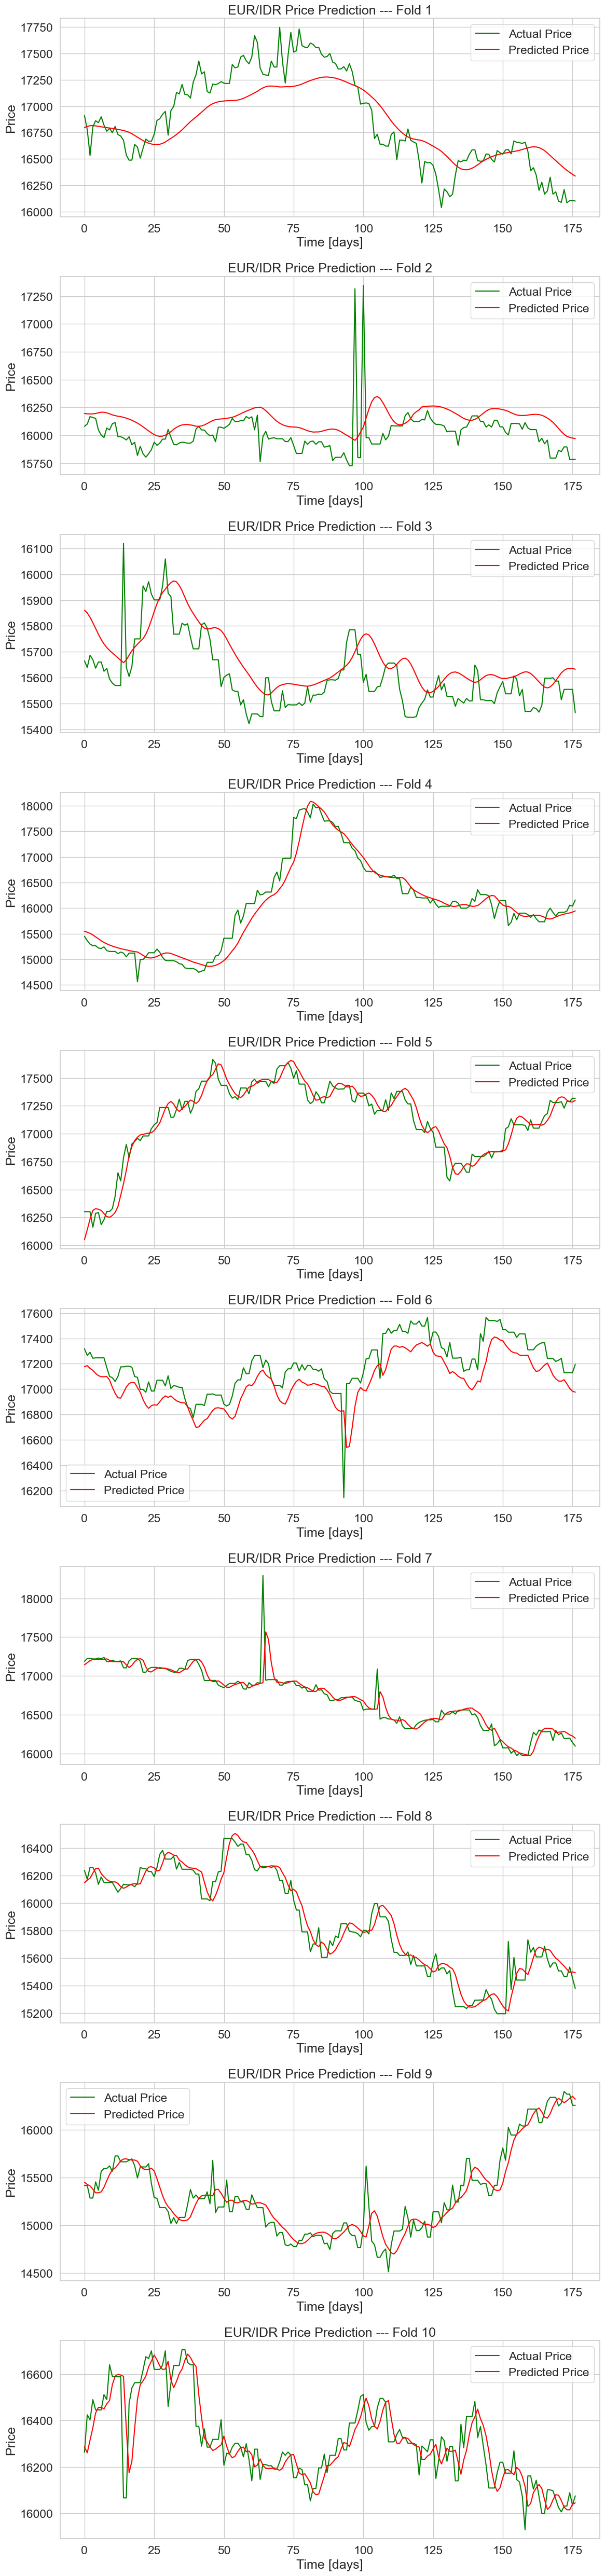

In [77]:
fig, axs = plt.subplots(FOLD, figsize=(12, FOLD*5))
for i in range(FOLD):
    axs[i].plot(y_test_per_fold[i], label="Actual Price", color='green')
    axs[i].plot(y_hat_inverse_per_fold[i], label="Predicted Price", color='red')

    axs[i].set_title(f'{SHEET_NAME[1]} Price Prediction --- Fold {i+1}')
    axs[i].set_xlabel('Time [days]')
    axs[i].set_ylabel('Price')
    axs[i].legend(loc='best')

plt.tight_layout()
plt.savefig(f'D:/Collage/Courses/Skripsi/Gambar/Hasil Skenario/{SHEET_NAME[1][:3]} Price Prediction_LSTM_{LSTM_Layer}_CV_{FOLD}_Window_{WINDOW_SIZE}.png')
plt.show()

In [78]:
error_result = pd.DataFrame([[SHEET_NAME[1], LSTM_Layer, WINDOW_SIZE, np.nan, FOLD, np.mean(metrics_inverse_per_fold[0]), np.mean(metrics_inverse_per_fold[1]), np.mean(metrics_inverse_per_fold[2])]],
                            columns=['Type', 'LSTM Layer', 'Window', 'Split', 'CV (Fold)', 'MAE', 'MSE', 'RMSE'])
hasil = pd.read_excel('Hasil.xlsx')
final = pd.concat([hasil, error_result], ignore_index=True)
final.to_excel('Hasil.xlsx', index=False)

In [79]:
import playsound

playsound.playsound('C:/Users/danie/Downloads/Music/laser_gun.mp3')